# Stock Volatility Forecasting Tool

**Authors:** Mate Papak, Filip Aleksić
**Mentor:** doc. dr. sc. Stjepan Begušić

This Jupyter Notebook serves as a tool for forecasting stock volatility. It contains various methods for predicting future volatility based on historical data.

## Introduction
In financial markets, volatility is a measure of the degree of variation of a financial instrument's price over time. It is an important factor in risk management and investment decision-making. Being able to accurately forecast volatility can help investors and traders make informed decisions and manage their portfolios effectively.

In this notebook, we utilize the standard deviation as a key measure of volatility. The standard deviation quantifies the dispersion of a set of values. In financial markets, it's used to gauge the variation or dispersion of a stock's returns. A high standard deviation signifies that the returns are dispersed over a wide range of values, indicating higher volatility. Conversely, a low standard deviation suggests that the returns are closely clustered around the mean, indicating lower volatility. By computing the standard deviation of the returns, we can estimate each stock's volatility, which can then be used to make informed investment decisions.

## Libraries

These are the Python libraries required for our research. Some of the important ones are:

- **pandas**: Provides data structuring capabilities.
- **matplotlib**: Enables data visualization and plotting.
- **numpy**: Supports numerical operations on data.
- **sklearn**: Contains various machine learning algorithms.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from collections import defaultdict
from IPython.display import display


## Data Preparation

In this research notebook, we're working with stock price data. We've chosen about 1000 active stocks and gathered data from 2000 to 2021. Please note that this data doesn't represent the entire market, as we've selected stocks that are currently active and likely have seen price growth over the past 20 years. To avoid bias, we'll focus our testing on the last 7 years. The `returns_df` dataframe shows the daily returns for each stock and will be used primarily for calculations.

Here's how to use the notebook:


## Step 1: Select Stocks

The notebook selects stocks from a DataFrame `prices_df` based on their position in the columns. You can adjust the selection by changing the numbers in the following lines of code:

   - `all_stocks = prices_df.columns[1:]`: This line selects all columns from the second one onwards. If you want to start from a different column, change the `1` to the number of the column you want to start from. For example, if you change it to `2`, it will exclude the first two columns. It's set to `1:` by default because we want to use all stocks, excluding the `Date` column (column 0).

   - `training_stocks = all_stocks[:200]`: This line selects the first 200 stocks to be used for training. If you want to use a different number of stocks for training, change `200` to that number. For example, if you change it to `100`, it will select the first 100 stocks for training.

   - `other_stocks = all_stocks[200:]`: This line selects all stocks from the 201st onwards to be used for testing purposes. If you want to start from a different stock, change `200` to that number. For example, if you change it to `100`, it will select all stocks from the 101st onwards.

Remember to run the cells after making any changes to apply them.

In [2]:
# Load data
prices_df = pd.read_csv('data\Russell3000_prices_clean.csv')
prices_df['Date'] = pd.to_datetime(prices_df['Date'], dayfirst=True)
prices_df.sort_values(by='Date', inplace=True)

# Select stocks to use; exclude the first column (date)
all_stocks = prices_df.columns[1:]
training_stocks = all_stocks[:200]
other_stocks = all_stocks[200:]

# Calculate returns
returns_df = prices_df[all_stocks].pct_change()
returns_df = returns_df.dropna().reset_index(drop=True)
returns_df.insert(0, 'Date', prices_df['Date'][:-1])

# Convert to numpy array (for easier calculations)
returns_matrix = returns_df.iloc[:, 1:].to_numpy()


## Step 2: Define Parameters

In this project, our goal is to make future predictions based on past data. We use 'windows' of past stock return data to forecast the volatility of future windows. The calculation of volatility over the past window can vary depending on the method we employ.

Here's what you need to understand about the variables:

- `windows`: These represent the sizes of the windows that will examine past returns. The predicted volatility is calculated based on these past returns.
- `forecast_horizon`: This is the size of the future window for which we are predicting volatility.
- `start_date` and `end_date`: These define the period during which we are testing our methods.

To utilize the notebook, you'll need to adjust these parameters to suit your requirements. For instance, you might want to modify the `windows` sizes, the `forecast_horizon`, or the `start_date` and `end_date` for testing. Please note that the `start_date` and `end_date` might be adjusted based on the conditions in the code to ensure they fall within the range of the available data. After setting the parameters, execute the cell to apply them.

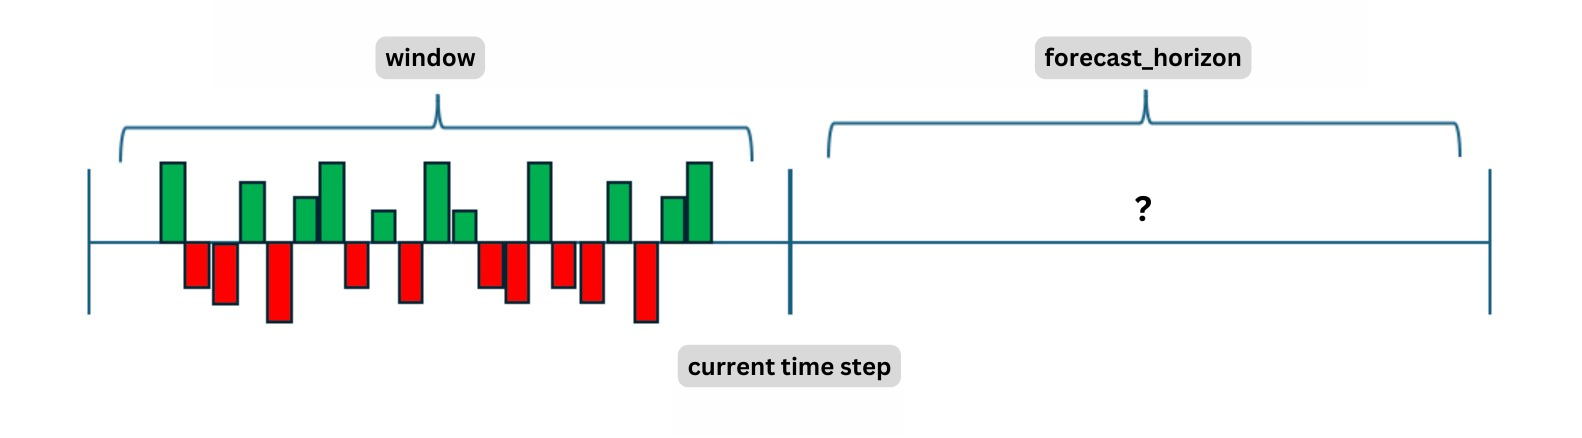

In [3]:
global windows, foreacast_horizon, test_start, test_end

windows = [21, 63, 126, 252] # month, quarter, half-year, year
forecast_horizon = 21 # trading days
test_start_date = pd.to_datetime('2015-01-01')
test_end_date = pd.to_datetime('2021-07-15')

messages = {"test_start": [], "test_end": []}

# Check if test_start_date exists in the DataFrame, if not, take the next date that exists
if test_start_date not in returns_df['Date'].values:
    test_start_date = \
        returns_df['Date'][returns_df['Date'] > test_start_date].bfill().iloc[0]
    messages["test_start"] = messages["test_start"] or \
        ['Start date not found, using closest next date instead.']

# Check if test_end_date exists in the DataFrame, if not, take the previous date that exists
if test_end_date not in returns_df['Date'].values:
    test_end_date = returns_df['Date'][returns_df['Date'] < test_end_date].ffill().iloc[-1]
    messages["test_end"] = messages["test_end"] or \
        ['End date not found, using closest date instead.']

test_start = returns_df.loc[returns_df['Date'] == test_start_date].index[0]
test_end = returns_df.loc[returns_df['Date'] == test_end_date].index[0]

if test_start < max(windows):
    test_start = max(windows)
    messages["test_start"] = messages["test_start"] or \
        ['Start date too early, not enough data for training.']

if test_end > len(returns_df):
    test_end = len(returns_df)
    messages["test_end"] = messages["test_end"] or \
        ['End date too late, not enough data for testing.']
    
if (test_end - test_start) % forecast_horizon != 0:
    test_end = test_end - (test_end - test_start) % forecast_horizon
    messages["test_end"] = messages["test_end"] or \
        ['End date not a multiple of forecast horizon.']

if messages["test_start"]:
    print('Adjusted tart date: {}. Reason: {}'.format(returns_df['Date'][test_start], \
                                                      ' '.join(messages["test_start"])))
if messages["test_end"]:
    print('Adjusted end date: {}. Reason: {}'.format(returns_df['Date'][test_end], '\
                                                      '.join(messages["test_end"])))

del test_start_date, test_end_date, messages

Adjusted tart date: 2015-01-02 00:00:00. Reason: Start date not found, using closest next date instead.
Adjusted end date: 2021-06-29 00:00:00. Reason: End date not a multiple of forecast horizon.


## Naive Risk Parity Portfolio

Naive Risk Parity is a portfolio construction strategy that aims to balance risk by assigning weights to stocks based on their volatility. Stocks with higher volatility are given lower weights, while stocks with lower volatility are given higher weights. This strategy seeks to minimize risk exposure by ensuring no single stock dominates the portfolio due to its risk.

Mathematically, the weight of each stock (i) in the portfolio is calculated as follows:

`weight_i = 1 / volatility_i`

Then, to ensure that the sum of all weights equals 1 (which is a requirement for portfolio weights), we normalize the weights:

`normalized_weight_i = weight_i / Σ(all_weights)`

So, the final formula for the weight of each stock in a Naive Risk Parity portfolio is:

`normalized_weight_i = (1 / volatility_i) / Σ(1 / volatility for all stocks)`

The `get_portfolio_weights` function takes a dictionary as an input, where each key-value pair represents a stock in our portfolio and its corresponding volatility. The function returns an array of weights, indicating the proportion of each stock in our portfolio. For instance, if the portfolio consists of three stocks, the function might return an array like this: `{'stock_1': 0.2, 'stock_2': 0.6, 'stock_3': 0.2}`, indicating that 'stock_1' and 'stock_3' each make up 20% of the portfolio, while 'stock_2' makes up 60%. Weight calculations are based on Nive Risk Parity.

In [4]:
def get_portfolio_weights(volatility):
    inv_volatilities = np.array([1/volatility[stock] \
                                 if volatility[stock] > 0 else 0 for stock in all_stocks])
    total = np.sum(inv_volatilities)
    return inv_volatilities / total if total > 0 else np.zeros(len(all_stocks))

The `methods` variable is a dictionary that stores the predicted volatilities and portfolio values for each method we're testing. Each key in the `methods` dictionary represents a method, and the value is another dictionary that contains the predicted volatilities for each stock and the portfolio values generated by that method.

The `gather_portfolio_metrics` function is used to add the predicted volatilities and portfolio values to the `methods` variable. This function takes the following inputs:

- The name of the method we're using
- The current time step
- A dictionary containing the volatilities of all stocks in the previous window

Here's an example of how it works:

1. We set the window size and forecast window to 21, the start date to January 2, 2015, and the end date to June 29, 2021. This means we're calculating the performance of the portfolios over that period.

2. We start at the start date and look at the previous 21 data points in the `returns_df` DataFrame.

3. We calculate the volatility over this window (the calculation method varies for each method) and assume that volatility for the next 21 days (the forecast window).

4. We do this for each stock and add the calculated volatilities to the `volatility` dictionary (which contains the predicted volatilities for the stocks).

5. After calculating the volatilities, we call the `gather_portfolio_metrics` function with the method, window size (21), current time step, and the `volatility` dictionary as inputs.

6. In this function, we add the `volatility` dictionary to the `methods` dictionary under the key of the method we're using.

7. We then call the `get_portfolio_weights` function with the `volatility` dictionary as an input to get the weights of the stocks in our portfolio.

8. Once we have the weights, we can see how our portfolio performs in the future window (the forecast window) by multiplying the weights with the matrix of actual returns. This gives us an array of returns, which represents the daily returns of our portfolio.

9. We add this array of returns to the `methods` dictionary under the key of the method we're using.

After running this function, the `methods` dictionary will contain the predicted volatilities for each stock and the realized returns of the portfolio for one method. We can repeat this process for different window sizes and methods.

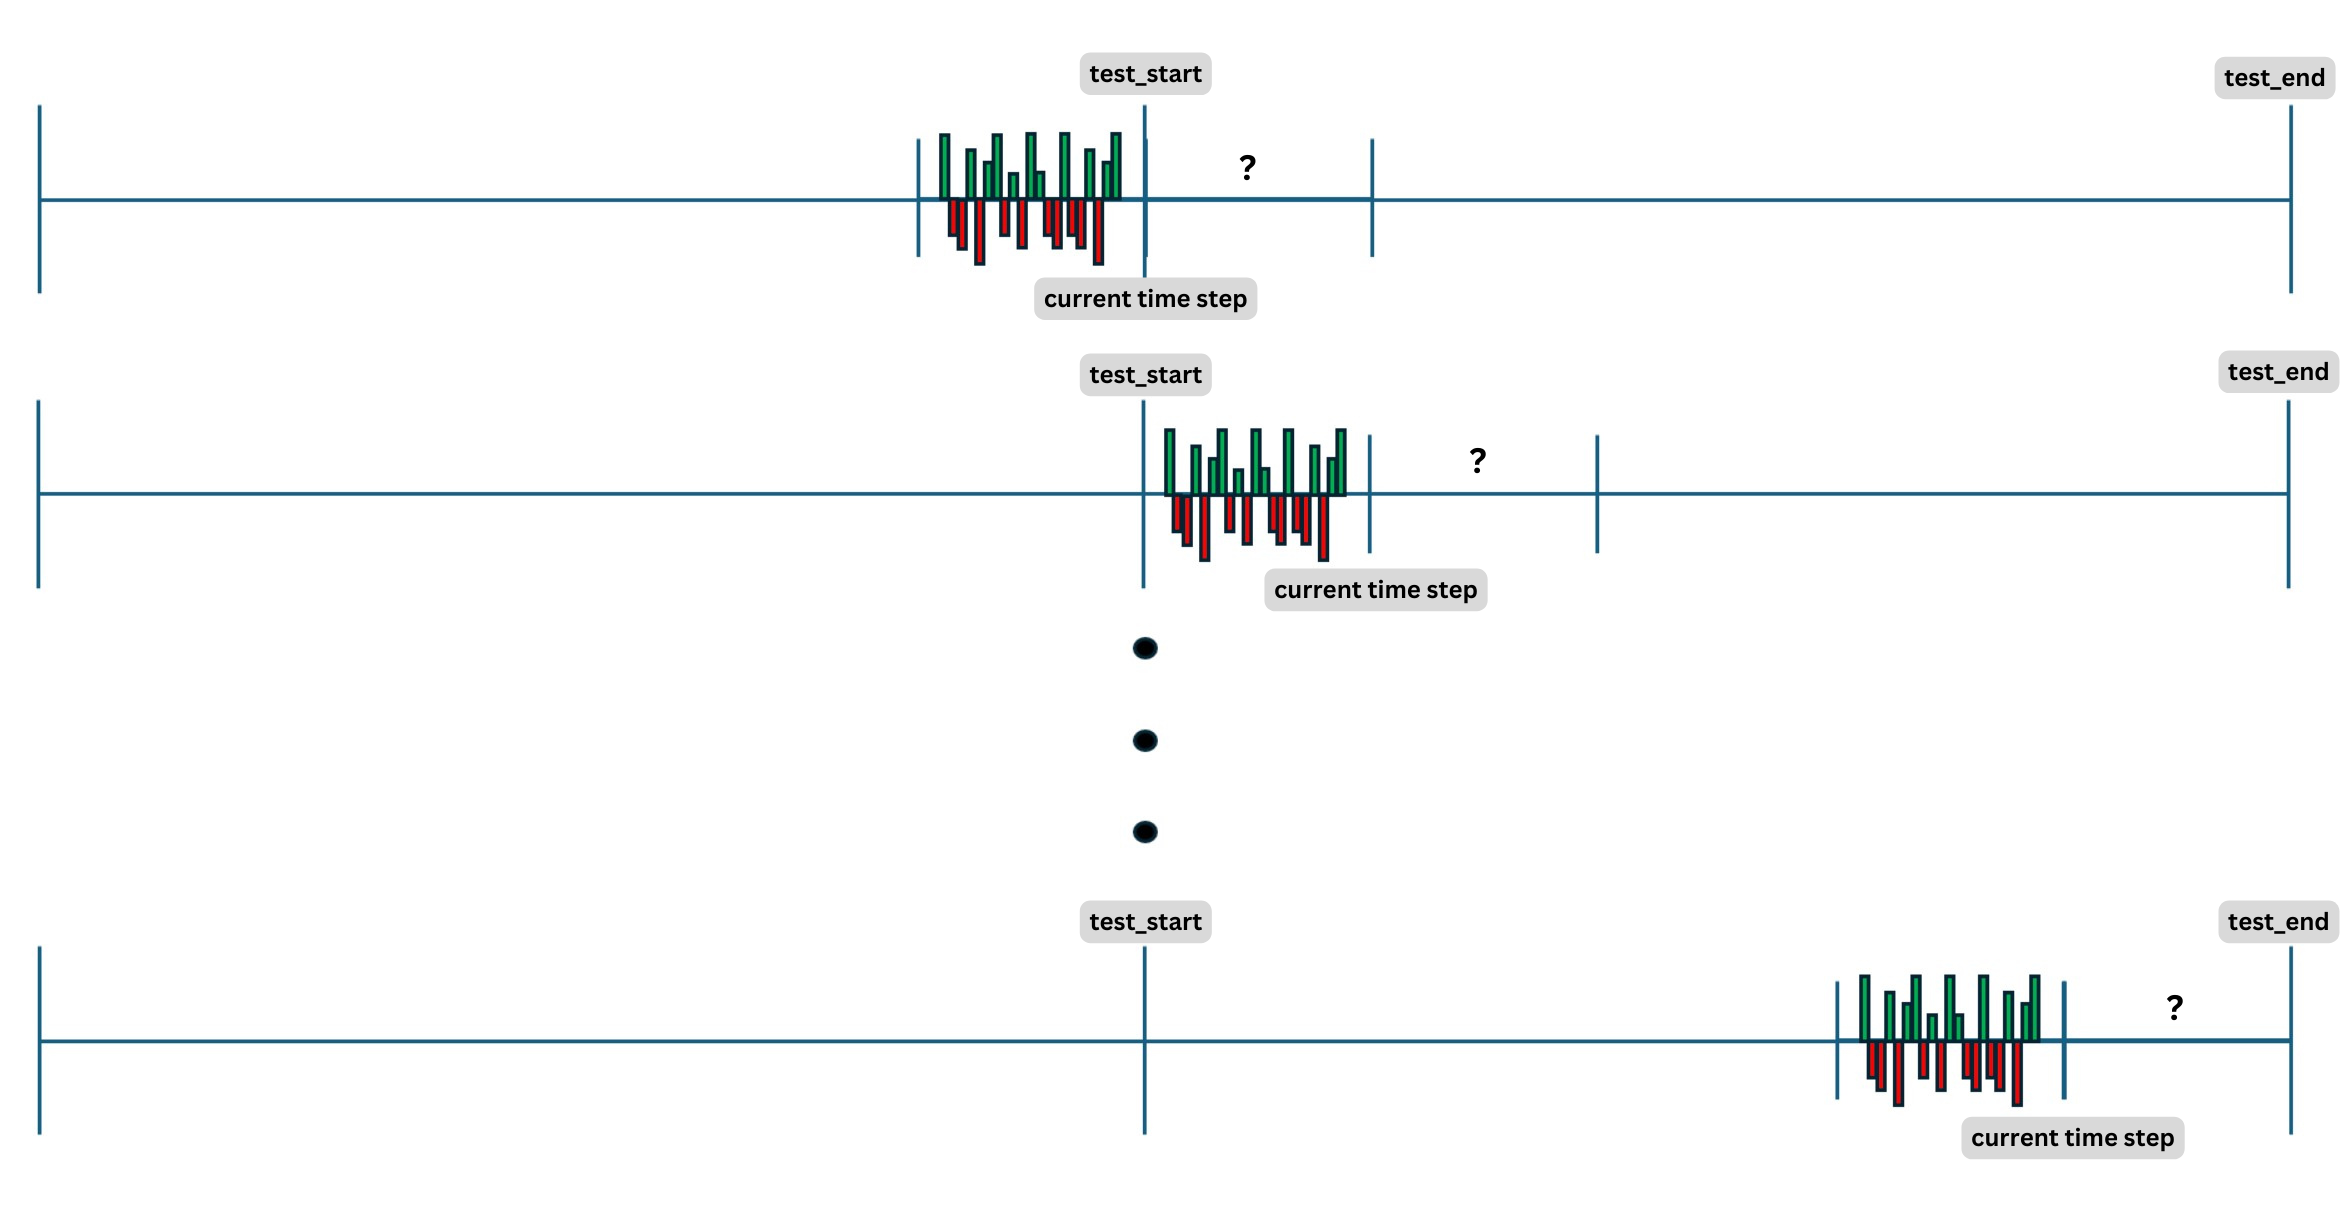

In [5]:
methods = defaultdict(lambda: defaultdict(list))

def gather_portfolio_metrics(method, i, volatility):
    # Record predicted volatility for each stock
    for stock in all_stocks:
        methods[method][stock + " predicted volatility"].extend([volatility[stock]])
        
    # Calculate portfolio weights based on volatility
    weights = get_portfolio_weights(volatility)
    
    # Calculate portfolio returns for each day in the window
    returns = np.dot(returns_matrix[i:i+forecast_horizon], weights)
    
    # Record portfolio returns
    methods[method]["returns"].extend(returns)


In [6]:
def reset_portfolio_metrics(method):
    for stock in all_stocks:
        methods[method][stock + " predicted volatility"] = []
    methods[method]["returns"] = []

## Equal Weight Portfolio

The Equal Weight Portfolio is a straightforward yet effective strategy often used as a benchmark in portfolio management. In this approach, all stocks in the portfolio are assigned equal weights, meaning the investment is distributed evenly across all stocks, regardless of their market value or other characteristics.

The strategy behind an Equal Weight Portfolio involves selling stocks that have increased in value and buying those that have decreased. This method ensures a constant rebalancing of the portfolio, which can lead to high returns over the long term. 

One of the key advantages of this strategy is that it gives equal importance to smaller stocks in a rising market. This can result in high returns as these smaller, often undervalued, stocks have the potential for significant growth.

In [7]:
method = "EqualWeight"
reset_portfolio_metrics(method)

for i in range(test_start, test_end, forecast_horizon):
    # We assume equal volatility across all stocks, simplifying our model to equal weights.
    volatility = {stock: 1 for stock in all_stocks}

    gather_portfolio_metrics(method, i, volatility)

## Testing Methods

In the following sections, we will conduct tests using various methods. Each method follows the implementation explained earlier, but with a unique approach to predicting future volatility. This is achieved by using different inputs and outputs with the functions we calculate. 

After predicting the volatilities, they are input into the **Naive Risk Parity Portfolio**. This calculates the proportion of each stock in our portfolio, which we refer to as 'weights'. Using these weights, we then compute the portfolio values.

If the `forecast_window` is set to 21 days, this means that we will be recalculating the volatilities and adjusting the weights in our portfolios every month. This approach allows us to adapt our portfolio based on the most recent volatility predictions, helping us manage risk more effectively.

## I. Oracle Method

The Oracle method serves as another benchmark in our study. Unlike other methods that will use past data to predict future volatility, the Oracle method uses the actual volatility from the future window as its prediction. In other words, it's as if this method can see into the future, hence the name "Oracle".

This method provides us with a theoretical lower bound on the prediction error. Since it uses the actual future volatility, any other method that predicts based on past data will inherently have a higher error. Therefore, the Oracle method serves as a useful benchmark to understand the best possible performance we could achieve if we had perfect foresight.

In [8]:
method = "Oracle" + "+" + str(forecast_horizon)
reset_portfolio_metrics(method)

for i in range(test_start, test_end, forecast_horizon):
    # Trying to predict the volatility of the next forecast_horizon days
    volatility = {stock: returns_df[stock][i: i + forecast_horizon].std() \
                  for stock in all_stocks}

    gather_portfolio_metrics(method, i, volatility)

## II. Sample Method

The Sample method is one of the simpler approaches in our project. It operates on the premise that the future volatility of a stock can be estimated based on its past volatility. Specifically, it calculates the standard deviation of the returns in the past window using the `.std()` function and assumes that the future volatility will be the same. We tested the Sample method using past windows of 1, 3, 6, and 12 months to evaluate its performance over different time frames.

In [9]:
for window in windows:
    method = "Sample" + "-" + str(window)
    reset_portfolio_metrics(method)
    for i in range(test_start, test_end, forecast_horizon):
        # Trying to predict the volatility of the next forecast_horizon days
        volatility = {stock: returns_df[stock][i - window: i].std() for stock in all_stocks}

        gather_portfolio_metrics(method, i, volatility)

## III. Exponential Weight Method

The Exponential Weight method is a modified version of the Sample method. While the Sample method treats each day in the past window equally when calculating future volatility, the Exponential Weight method assigns exponentially more importance to recent days. For instance, returns from yesterday and the day before are considered more significant than returns from a month ago when calculating volatility.

The graph below illustrates how much each day is taken into account in a window of 21 days. The 21st day has around 8% influence in calculating volatility, while the 1st day has around 2%. The idea behind the Exponential Weight method is that more recent return data better describes future volatility.

Function explanations:
- `get_exponential_weights`: This function takes the window size as input and returns the weights of the day's influence in that window.
- `get_weighted_volatility`: This function takes the weights of the day's influence in the window and the array of returns as input, and returns the volatility of that window adjusted according to the weights of the days.

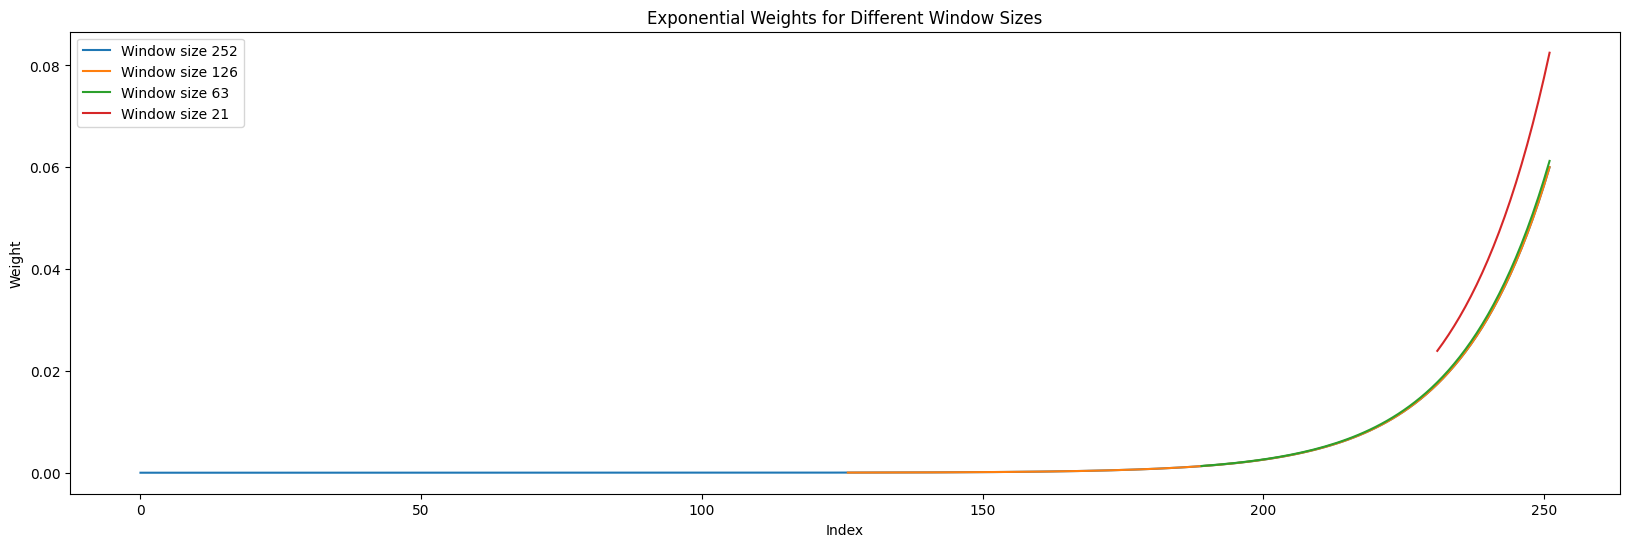

In [10]:
def get_exponential_weights(size, const=0.94):
    weights = [const**i for i in range(size, 0, -1)]
    total = sum(weights)
    return [weight / total for weight in weights]
    
plt.figure(figsize=(20, 6))
for window in windows[::-1]:
    weights = [None]*(max(windows) - window) + get_exponential_weights(window)
    plt.plot(weights, label=f'Window size {window}')
plt.title('Exponential Weights for Different Window Sizes')
plt.xlabel('Index')
plt.ylabel('Weight')
plt.legend()
plt.show()

In [11]:
def get_weighted_volatility(weights, returns):
    variance = sum(weights * returns**2)
    return variance**0.5

for window in windows:
    method = "ExponentialWeight" + "-" + str(window)
    reset_portfolio_metrics(method)

    weights = get_exponential_weights(window)
    for i in range(test_start, test_end, forecast_horizon):
        #  Trying to predict the volatility of the next forecast_horizon days
        volatility = {stock: get_weighted_volatility(\
            weights, returns_df[stock][i - window: i]) for stock in all_stocks}

        gather_portfolio_metrics(method, i, volatility)

## IV. Least Squares Linear Regression Method

The Least Squares Linear Regression is a method that aims to minimize the sum of the squares of the differences between the predicted and actual values. In this case, we're predicting volatility. The goal is to optimally adjust the model to achieve the best results. The following four methods are all based on linear regression, but they differ in terms of input data and adjustment methods.

`Train_start` is the point in time when we start training our models. In this case, it's the earliest data point we have.

`Train_end` is the point in time up to which we train. This is equal to the point when we start testing, also known as `test_start`.

The `get_linear_regression_model` function takes in data A and B, where A represents the input data based on which we need to predict B. The model is trained using the built-in `LinearRegression` function. The four methods of linear regression will have different A and B inputs, and they will train their models using this function. These trained models will then be used to predict future volatility.

In [12]:
global window, train_start, train_end
window = 21 # Set window to 21 days from now on for computational efficiency
train_start = (test_start - window) % forecast_horizon + window # 
train_end = test_start # Training end is the start of the test period

A, B = [], []
def get_linear_regression_model(A, B, fit_intercept=True):
    # Fit a linear regression model with non-negative coefficients and no intercept
    model = LinearRegression(positive=True, fit_intercept=fit_intercept)
    model.fit(np.array(A), np.array(B))
    A.clear()
    B.clear()

    return model

## a) Linear Regression (return^2, variance)

The next method we're discussing is Linear Regression, which uses squared daily returns as input data and predicts the variance of the future window.

In this method, we're essentially trying to establish a linear relationship between the squared daily returns of a stock and its future volatility. The assumption here is that periods of high daily returns (both positive and negative, hence squared returns) are likely to be followed by high volatility.

The Linear Regression model is trained on this historical data, and it learns to predict future volatility based on the pattern it observes in the squared daily returns. Once the model is trained, it can be used to predict the volatility of the future window based on the squared daily returns in the current window.

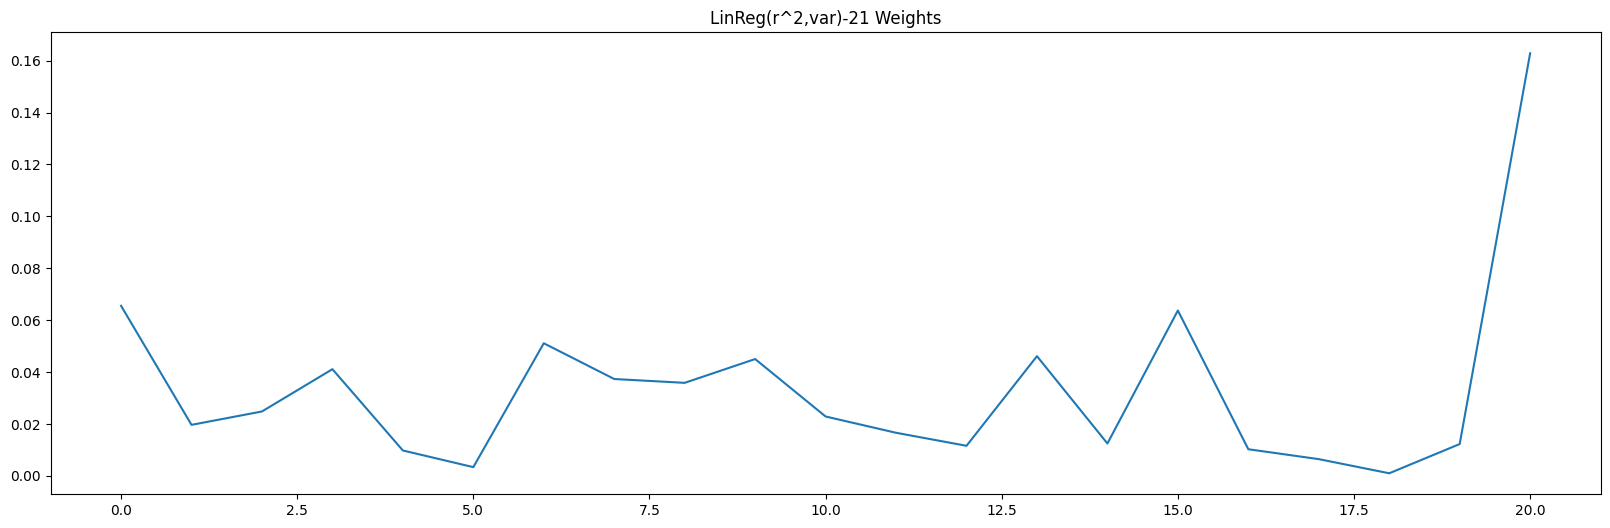

In [13]:
method = "LinReg(r^2,var)" + "-" + str(window)
reset_portfolio_metrics(method)

# Iterate over each window of returns
for stock in training_stocks:
    for i in range(train_start, train_end, forecast_horizon):
        # Append squared returns and variance of returns to A and B respectively
        A.append(returns_df[stock][i - window:i] ** 2)
        B.append(returns_df[stock][i:i + forecast_horizon].var())

methods[method]["model"] = get_linear_regression_model(A, B, False) 
# Intercept might make variance negative

plt.figure(figsize=(20, 6))
plt.plot(methods[method]["model"].coef_)
plt.title(method + " Weights")
plt.show()

In [14]:
for i in range(test_start, test_end, forecast_horizon):
    #  Trying to predict the volatility of the next forecast_horizon days
    volatility = {stock: methods[method]["model"].predict(\
        returns_df[stock][i - window: i].values.reshape(1, -1)**2)[0]**0.5 \
            for stock in all_stocks}
    
    gather_portfolio_metrics(method, i, volatility)

## b) Individual Linear Regression (return^2, variance)

The next method we're discussing is Individual Linear Regression. This method, like the previous one, uses squared daily returns as input data and predicts the variance of the future window. However, there's a key difference: in this method, we calculate optimal weights for each stock individually.

In other words, instead of using a single linear regression model to predict future volatility for all stocks, we use a separate model for each stock. This allows us to capture the unique characteristics and patterns of each stock's returns, potentially leading to more accurate volatility predictions.

The assumption behind this method is that each stock may have its own unique relationship between past returns and future volatility, and by modeling each stock individually, we can better capture these relationships.

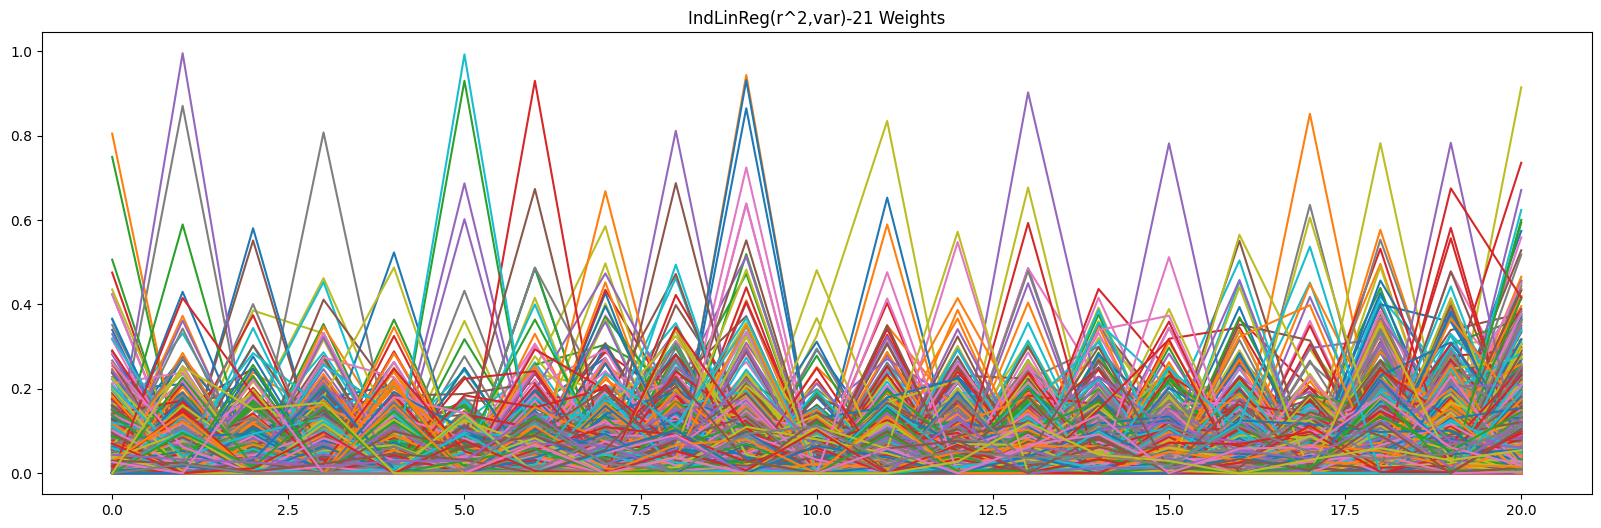

In [15]:
method = "IndLinReg(r^2,var)" + "-" + str(window)
reset_portfolio_metrics(method)

# Store individual models for each stock
for stock in all_stocks:
    for i in range(train_start, train_end, forecast_horizon):
        # Append squared returns and variance of returns to A and B respectively
        A.append(returns_df[stock][i - window:i] ** 2)
        B.append(returns_df[stock][i:i + forecast_horizon].var())

    methods[method][stock + "model"] = get_linear_regression_model(A, B, False)

plt.figure(figsize=(20, 6))
for stock in all_stocks:
    if all(methods[method][stock + "model"].coef_ < 1):
        plt.plot(methods[method][stock + "model"].coef_) 
plt.title(method + " Weights")
plt.show()

In [16]:
for i in range(test_start, test_end, forecast_horizon):
    #  Trying to predict the volatility of the next forecast_horizon days
    volatility = {stock: methods[method][stock + "model"].predict(\
        returns_df[stock][i - window: i].values.reshape(1, -1)**2)[0]**0.5 \
            for stock in all_stocks}

    gather_portfolio_metrics(method, i, volatility)

## c) Linear Regression (return^2, standard deviation)

The method remains the same - Linear Regression - and the input data continues to be the squared daily returns. The key difference lies in the output we aim to predict: instead of variance, we now focus on the standard deviation. The trained model, therefore, predicts the standard deviation of the future window based on the squared daily returns in the current window.

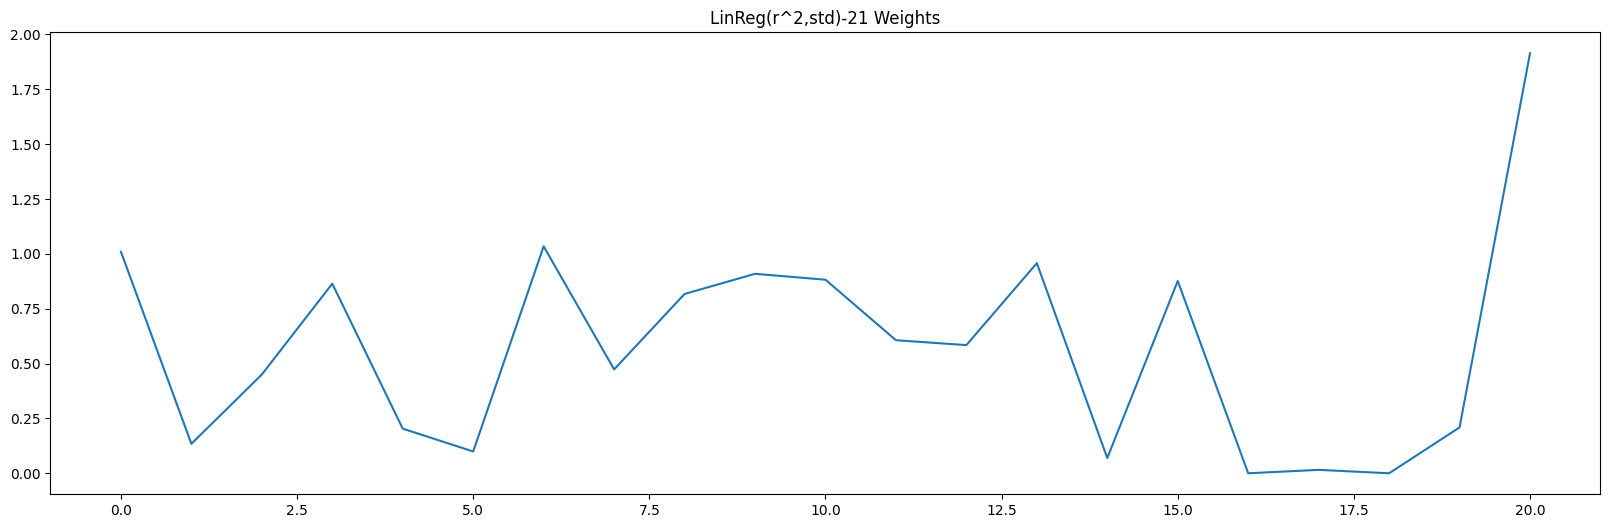

In [17]:
method = "LinReg(r^2,std)" + "-" + str(window)
reset_portfolio_metrics(method)

# Iterate over each window of returns
for stock in training_stocks:
    for i in range(train_start, train_end, forecast_horizon):
        # Append squared returns and variance of returns to A and B respectively
        A.append(returns_df[stock][i - window:i] ** 2)
        B.append(returns_df[stock][i:i + forecast_horizon].std())

methods[method]["model"] = get_linear_regression_model(A, B, False) 
# Intercept might make variance negative

plt.figure(figsize=(20, 6))
plt.plot(methods[method]["model"].coef_)
plt.title(method + " Weights")
plt.show()

In [18]:
for i in range(test_start, test_end, forecast_horizon):
    #  Trying to predict the volatility of the next forecast_horizon days
    volatility = {stock: methods[method]["model"].predict(\
        returns_df[stock][i - window: i].values.reshape(1, -1)**2)[0] \
            for stock in all_stocks}
    
    gather_portfolio_metrics(method, i, volatility)

## d) Individual Linear Regression (return^2, standard deviation)

In this section, we apply the same Linear Regression method, but now we tailor it to each individual stock. We continue to use squared daily returns as input data and predict the standard deviation.

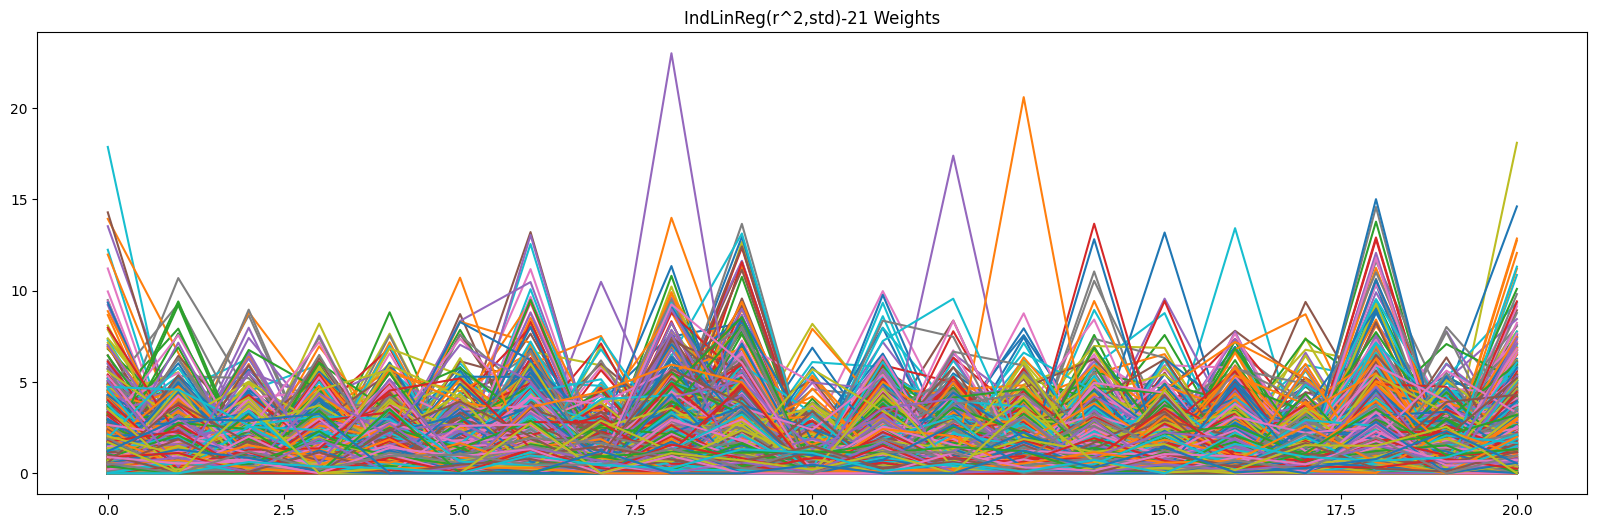

In [19]:
method = "IndLinReg(r^2,std)" + "-" + str(window)
reset_portfolio_metrics(method)

# Store individual models for each stock
for stock in all_stocks:
    for i in range(train_start, train_end, forecast_horizon):
        # Append squared returns and variance of returns to A and B respectively
        A.append(returns_df[stock][i - window:i] ** 2)
        B.append(returns_df[stock][i:i + forecast_horizon].std())

    methods[method][stock + "model"] = get_linear_regression_model(A, B, False)

plt.figure(figsize=(20, 6))
for stock in all_stocks:
    plt.plot(methods[method][stock + "model"].coef_) 
plt.title(method + " Weights")
plt.show()

In [20]:
for i in range(test_start, test_end, forecast_horizon):
    # Trying to predict the volatility of the next forecast_horizon days
    volatility = {stock: methods[method][stock + "model"].predict(\
        returns_df[stock][i - window: i].values.reshape(1, -1)**2)[0] \
            for stock in all_stocks}

    gather_portfolio_metrics(method, i, volatility)

## e) Linear Regression (log(1+return), log(variance))

In this variant, we apply Linear Regression using the natural logarithm of one plus the daily returns as input and the natural logarithm of variance as the output. This transformation can help stabilize variance and make the data more suitable for Linear Regression.

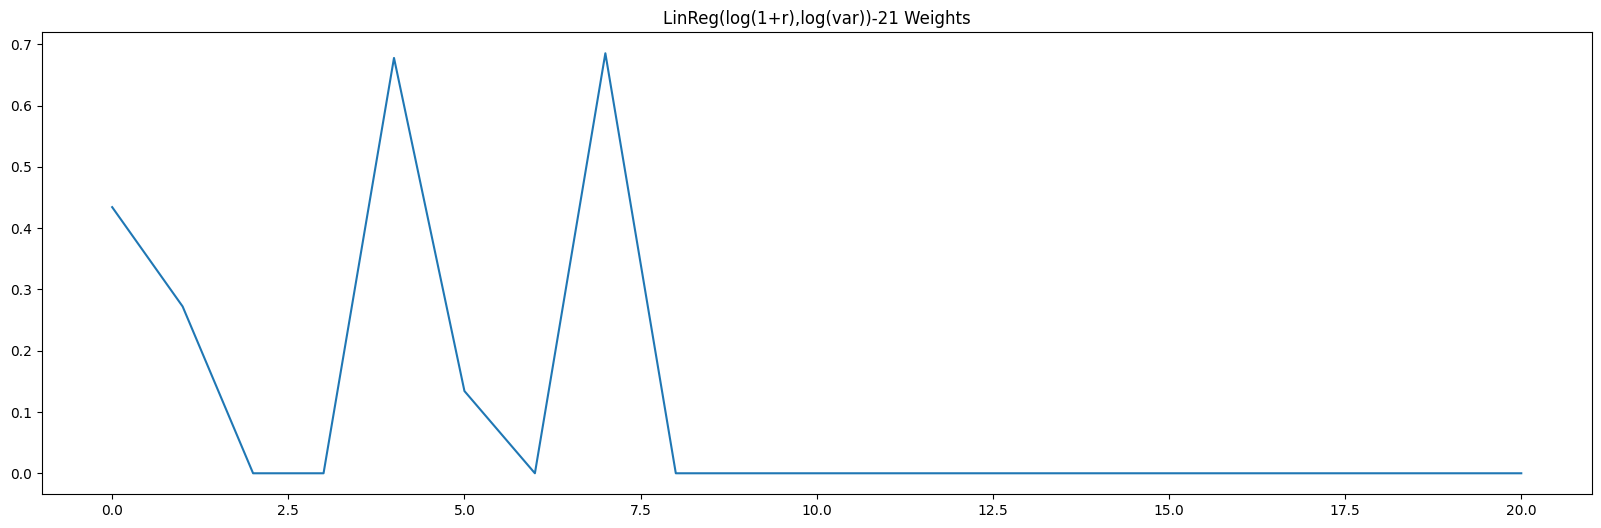

In [21]:
method = "LinReg(log(1+r),log(var))" + "-" + str(window)
reset_portfolio_metrics(method)

# Iterate over each window of returns
for stock in training_stocks:
    for i in range(train_start, train_end, forecast_horizon):
        variance = returns_df[stock][i:i + forecast_horizon].var()
        if variance > 0: # If variance is 0, we cannot take the log
            A.append(np.log(1 + returns_df[stock][i - window:i]))
            B.append(np.log(variance))

methods[method]["model"] = get_linear_regression_model(A, B)

plt.figure(figsize=(20, 6))
plt.plot(methods[method]["model"].coef_)
plt.title(method + " Weights")
plt.show()

In [22]:
for i in range(test_start, test_end, forecast_horizon):
    # Trying to predict the volatility of the next forecast_horizon days
    volatility = {stock: np.exp(methods[method]["model"].predict(\
        np.log(1+returns_df[stock][i - window: i].values.reshape(1, -1))))**0.5 \
            for stock in all_stocks}

    gather_portfolio_metrics(method, i, volatility)

## f) Individual Linear Regression (log(1+return), log(variance))

In this final variant, we apply the same Linear Regression method individually for each stock, using the natural logarithm of one plus the daily returns as input and the natural logarithm of variance as the output. This approach aims to capture the unique characteristics of each stock while benefiting from the stabilizing effect of the logarithmic transformation.

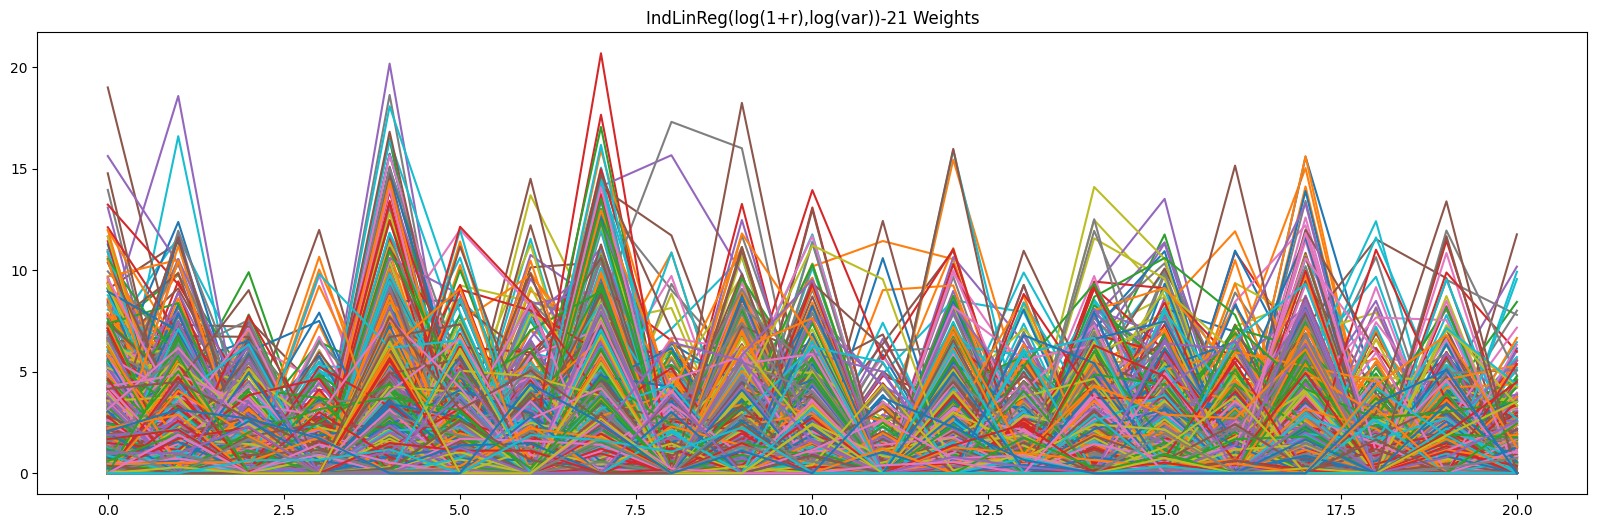

In [23]:
method = "IndLinReg(log(1+r),log(var))" + "-" + str(window)
reset_portfolio_metrics(method)

# Iterate over each window of returns
for stock in all_stocks:
    for i in range(train_start, train_end, forecast_horizon):
        variance = returns_df[stock][i:i + forecast_horizon].var()
        if variance > 0: # If variance is 0, we cannot take the log
            A.append(np.log(1 + returns_df[stock][i - window:i]))
            B.append(np.log(variance))

    methods[method][stock + "model"] = get_linear_regression_model(A, B)

plt.figure(figsize=(20, 6))
for stock in all_stocks:
    plt.plot(methods[method][stock + "model"].coef_)
plt.title(method + " Weights")
plt.show()

In [24]:
for i in range(test_start, test_end, forecast_horizon):
    # Trying to predict the volatility of the next forecast_horizon days
    volatility = {stock: np.exp(methods[method][stock + "model"].predict(\
        np.log(1+returns_df[stock][i - window: i].values.reshape(1, -1))))**0.5 \
            for stock in all_stocks}

    gather_portfolio_metrics(method, i, volatility)

## V. Random Forest Method

The Random Forest method is an ensemble learning technique that consists of multiple decision trees. Each tree is trained on a distinct subset of our data, a process known as bagging. Suppose our random forest consists of 100 trees. The main decision is made by taking the average value of all trees, which helps to avoid bias in our results.

Like the previous methods, we train the Random Forest model using past windows and the volatility of future windows. The goal is for the model to learn to predict future volatility based on the patterns it observes in the past data.

In the following sections, we will explore four variations of the Random Forest method. These variations differ in the form of the input data and the data they aim to predict.

In [25]:
def get_random_forest_model(A, B):
    # Fit a random forest
    model = RandomForestRegressor()
    model.fit(np.array(A), np.array(B))
    A.clear()
    B.clear()

    return model

## a) Random Forest (return, log(variance))

In this variant of the Random Forest method, we use the daily returns as input data and predict the natural logarithm of the variance.

The daily returns provide a direct measure of the changes in a stock's price, while the logarithm of the variance is a transformation that can help stabilize the variance and make the data more suitable for the Random Forest model.

The Random Forest model is trained on this historical data, and it learns to predict the logarithm of the future variance based on the pattern it observes in the daily returns. Once the model is trained, it can be used to predict the logarithm of the variance of the future window based on the daily returns in the current window.

In [26]:
method = "RandFor(r,log(var))" + "-" + str(window)
reset_portfolio_metrics(method)

# Iterate over each window of returns
for stock in training_stocks:
    for i in range(train_start, train_end, forecast_horizon):
        variance = returns_df[stock][i:i + forecast_horizon].var()
        if variance > 0: # If variance is 0, we cannot take the log
            A.append(returns_df[stock][i - window:i])
            B.append(np.log(variance))

methods[method]["model"] = get_random_forest_model(A, B)

for i in range(test_start, test_end, forecast_horizon):
    # 
    volatility = {stock: np.exp(methods[method]["model"].predict(\
        returns_df[stock][i - window: i].values.reshape(1, -1)))**0.5 \
            for stock in all_stocks}

    gather_portfolio_metrics(method, i, volatility)

## b) Random Forest (return^2, log(variance))

In this variant, we use squared daily returns as input data. Squaring the returns emphasizes periods of high change, both positive and negative. We continue to predict the natural logarithm of the variance, providing a stabilized measure of volatility.

In [27]:
method = "RandFor(r^2,log(var))" + "-" + str(window)
reset_portfolio_metrics(method)

# Iterate over each window of returns
for stock in training_stocks:
    for i in range(train_start, train_end, forecast_horizon):
        variance = returns_df[stock][i:i + forecast_horizon].var()
        if variance > 0: # If variance is 0, we cannot take the log
            A.append(returns_df[stock][i - window:i]**2)
            B.append(np.log(variance))

methods[method]["model"] = get_random_forest_model(A, B)

for i in range(test_start, test_end, forecast_horizon):
    # 
    volatility = {stock: np.exp(methods[method]["model"].predict(\
        returns_df[stock][i - window: i].values.reshape(1, -1)**2))**0.5 \
            for stock in all_stocks}

    gather_portfolio_metrics(method, i, volatility)

## c) Random Forest (|return|, log(variance))

In this approach, we use the absolute value of daily returns as input data. This emphasizes the magnitude of changes, regardless of direction. The output remains the natural logarithm of the variance.

In [28]:
method = "RandFor(|r|,log(var))" + "-" + str(window)
reset_portfolio_metrics(method)

# Iterate over each window of returns
for stock in training_stocks:
    for i in range(train_start, train_end, forecast_horizon):
        variance = returns_df[stock][i:i + forecast_horizon].var()
        if variance > 0: # If variance is 0, we cannot take the log
            A.append(abs(returns_df[stock][i - window:i]))
            B.append(np.log(variance))

methods[method]["model"] = get_random_forest_model(A, B)

for i in range(test_start, test_end, forecast_horizon):
    # 
    volatility = {stock: np.exp(methods[method]["model"].predict(\
        abs(returns_df[stock][i - window: i].values.reshape(1, -1))))**0.5 \
            for stock in all_stocks}

    gather_portfolio_metrics(method, i, volatility)

## d) Random Forest (log(1+return), log(variance))

For this variant, we use the natural logarithm of one plus the daily returns as input data. This transformation can help stabilize the returns. We continue to predict the natural logarithm of the variance.

In [29]:
method = "RandFor(log(1+r),log(var))" + "-" + str(window)
reset_portfolio_metrics(method)

# Iterate over each window of returns
for stock in training_stocks:
    for i in range(train_start, train_end, forecast_horizon):
        variance = returns_df[stock][i:i + forecast_horizon].var()
        if variance > 0: # If variance is 0, we cannot take the log
            A.append(np.log(1 + returns_df[stock][i - window:i]))
            B.append(np.log(variance))

methods[method]["model"] = get_random_forest_model(A, B)

for i in range(test_start, test_end, forecast_horizon):
    # 
    volatility = {stock: np.exp(methods[method]["model"].predict(\
        np.log(1 + returns_df[stock][i - window: i].values.reshape(1, -1))))**0.5 \
            for stock in all_stocks}

    gather_portfolio_metrics(method, i, volatility)

In [42]:
method = "RandFor(r^2,std)" + "-" + str(window)
reset_portfolio_metrics(method)

del methods[method]

## Portfolio Performance

In the following sections, we will create a portfolio for each method and calculate key performance metrics. These metrics include the volatility standard deviation, which measures the volatility or risk associated with the portfolio, the average annual return, which indicates the average amount of profit or loss made by the portfolio over a year, and the Sharpe ratio, which measures the performance of an investment compared to a risk-free asset, after adjusting for its risk. 

By evaluating these metrics, we can gain insights into the risk and return characteristics of each portfolio, and assess the effectiveness of each method in terms of its risk-adjusted return. 

Additionally, we will highlight the top 3 performers for each metric. This will allow us to easily identify the methods that have the highest return, highest Sharpe ratio, and lowest volatility.

In [43]:
portfolios_df = {
    "Portfolio": [method for method in methods],
    "Volatility": [np.std(portfolio["returns"]) * 252**0.5 \
                   for portfolio in methods.values()],
    "Return": [(1 + np.average(portfolio["returns"]))**252 - 1 \
               for portfolio in methods.values()],
    "Sharpe": [((1 + np.average(portfolio["returns"]))**252 - 1) \
               / (np.std(portfolio["returns"]) * 252**0.5) \
                for portfolio in methods.values()]
}

def highlight_top3_max(s):
    is_top3 = s.isin(s.nlargest(3))
    return ['background-color: yellow' if v else '' for v in is_top3]

def highlight_top3_min(s):
    is_top3 = s.isin(s.nsmallest(3))
    return ['background-color: yellow' if v else '' for v in is_top3]

display(pd.DataFrame(portfolios_df).style.apply(\
    highlight_top3_max, subset=['Return', 'Sharpe']).apply(\
        highlight_top3_min, subset=['Volatility']))

,Portfolio,Volatility,Return,Sharpe
0,EqualWeight,0.215308,0.198808,0.923362
1,Oracle+21,0.188517,0.178922,0.949102
2,Sample-21,0.198320,0.175103,0.882935
3,Sample-63,0.199813,0.173604,0.868832
4,Sample-126,0.200192,0.170751,0.852939
5,Sample-252,0.201409,0.172843,0.858170
6,ExponentialWeight-21,0.197818,0.175251,0.885921
7,ExponentialWeight-63,0.198568,0.174741,0.880007
8,ExponentialWeight-126,0.198625,0.174579,0.878938
9,ExponentialWeight-252,0.198626,0.174586,0.878970


## Portfolio Value Evaluation

In this section, we will evaluate the value of each portfolio over our test period, assuming an initial investment of 1. 

By tracking the portfolio value over time, we can assess the performance of each method in terms of its ability to increase the value of the initial investment. This will provide us with another perspective on the effectiveness of each method, complementing the risk and return metrics calculated in the previous section.

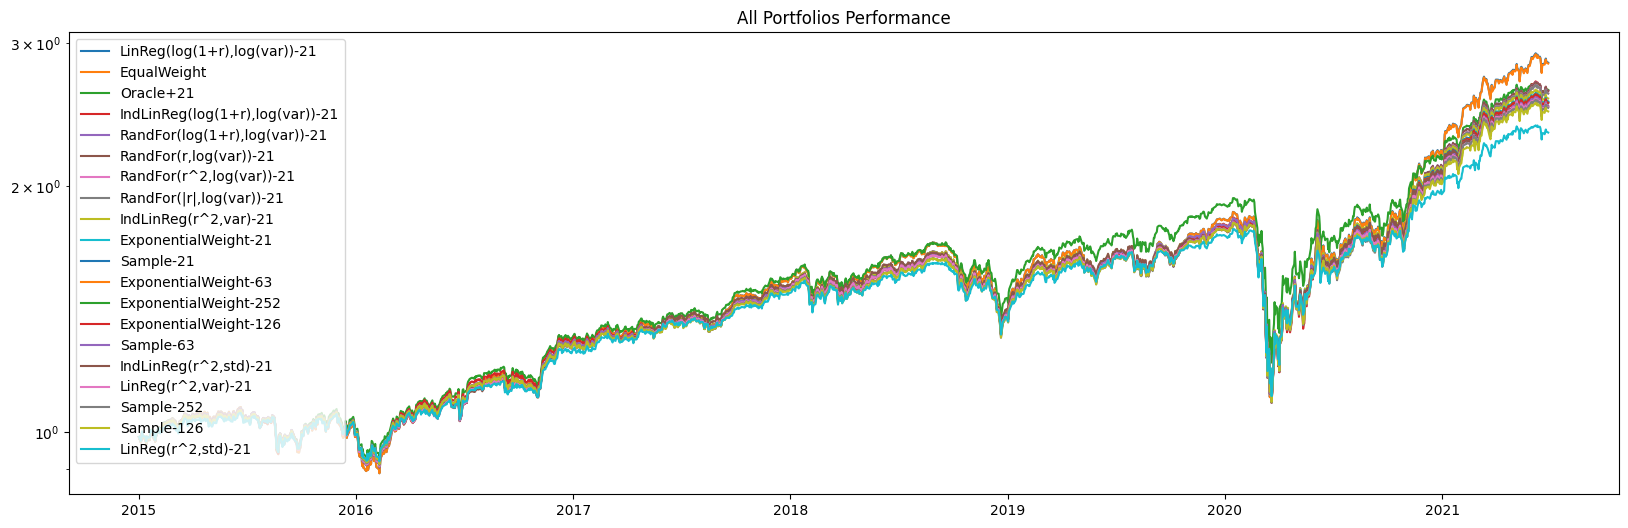

In [44]:
# Iterate over each portfolio in methods
for portfolio in methods.values():
    # Initialize the value list with a starting value of 1
    portfolio["value"] = [1]

    # Calculate the cumulative value of the portfolio
    for ret in portfolio["returns"]:
        portfolio["value"].append((ret + 1) * portfolio["value"][-1])

# Get the dates for the test period
dates = returns_df.iloc[test_start:test_end, 0]

# Sort the methods by the final value of the portfolio, in descending order
sorted_methods = sorted(\
    methods.items(), key=lambda method: method[1]["value"][-1], reverse=True)

# Plot the performance of all portfolios
plt.figure(figsize=(20, 6))
for method, portfolio in sorted_methods:
    plt.semilogy(dates, portfolio["value"][1:], label=method)
plt.title("All Portfolios Performance")
plt.legend()
plt.show()

## Mean Squared Error

Mean Squared Error (MSE) is a common metric used in regression analysis to measure the quality of a predictive model. It calculates the average of the squares of the differences between the actual and predicted values. 

The formula for MSE is:

`(1/n) * Σ(actual - prediction)²`

Where:
- `n` is the total number of observations
- `Σ` is the sum of the differences between the actual and predicted values, each squared

A lower MSE indicates a better fit of the model to the data. However, because MSE squares the differences, it can disproportionately penalize larger errors, which might not always be desirable depending on the specific context.

In [45]:
def calculate_mse(actual, predicted, stocks=all_stocks):
    mse = []
    for stock in stocks:
        mse.append(mean_squared_error(\
            actual[stock + " predicted volatility"], \
                predicted[stock + " predicted volatility"]))
    return np.mean(mse)

## Method Performance

In this section, we evaluate the performance of various prediction methods by calculating their Mean Squared Error (MSE) on predicting stock volatility. Each method's performance is assessed in three different contexts:

1. **MSE All Stocks**: This measures the method's performance on predicting the volatility for all stocks in the dataset.
2. **MSE Trained Stocks**: This measures the method's performance on just the stocks that the method was trained on.
3. **MSE Other Stocks**: This measures the method's performance on the stocks that were not included in the training set.

Some prediction methods do not have separate "Trained Stocks" and "Other Stocks" categories due to the nature of the method. For these methods, all stocks are used for training.

By comparing these metrics, we can understand how each method performs overall, as well as how its performance varies between the stocks it was trained on and those it was not. This can provide insights into the method's ability to generalize from its training data to unseen data, which is a key aspect of machine learning model performance.

To aid in this comparison, the three best-performing methods in each category are highlighted. This allows for a quick visual assessment of which methods tend to perform best across different contexts.

In [46]:
methods_df = {
    "Method": [method for method in methods],
    "MSE All Stocks": [calculate_mse(\
        methods["Oracle+" + str(forecast_horizon)], methods[method]) \
            if method != "EqualWeight" else None for method in methods],
    "MSE Trained Stocks": [calculate_mse(\
        methods["Oracle+" + str(forecast_horizon)], methods[method], training_stocks) \
            if all(not method.startswith(prefix) \
                for prefix in ["EqualWeight", "Sample", "ExponentialWeight", "IndLinReg"]) \
                    else None for method in methods],
    "MSE Other Stocks": [calculate_mse(\
        methods["Oracle+" + str(forecast_horizon)], methods[method], other_stocks) \
            if all(not method.startswith(prefix) \
                for prefix in ["EqualWeight", "Sample", "ExponentialWeight", "IndLinReg"]) \
                    else None for method in methods]
}

display(pd.DataFrame(methods_df).loc[lambda df: df['Method'] != 'EqualWeight'].style.apply(\
    highlight_top3_min, subset=['MSE All Stocks', 'MSE Trained Stocks', 'MSE Other Stocks']))

,Method,MSE All Stocks,MSE Trained Stocks,MSE Other Stocks
1,Oracle+21,0.000000,0.000000,0.000000
2,Sample-21,0.000347,nan,nan
3,Sample-63,0.000324,nan,nan
4,Sample-126,0.000327,nan,nan
5,Sample-252,0.000323,nan,nan
6,ExponentialWeight-21,0.000323,nan,nan
7,ExponentialWeight-63,0.000303,nan,nan
8,ExponentialWeight-126,0.000302,nan,nan
9,ExponentialWeight-252,0.000302,nan,nan
10,"LinReg(r^2,var)-21",0.000319,0.000123,0.000359


## Conclusion

Predicting stock volatility is a complex yet rewarding endeavor. It offers invaluable insights that can guide investment strategies and risk management decisions. In this notebook, we've established a robust framework for implementing and evaluating various volatility forecasting methods. 

Through our comparative analysis, we've shed light on the performance of each method in different contexts - predicting volatility for all stocks, for the stocks they were trained on, and for those they were not. This comprehensive evaluation allows us to understand not only the overall effectiveness of each method but also their ability to generalize their predictions to unseen data.

Happy forecasting!

In [48]:
del window, i, volatility, train_start, train_end, test_start, test_end, forecast_horizon, \
    windows, A, B, variance, dates, portfolio, weights, ret, returns_matrix, methods, \
        stock, method, all_stocks, other_stocks, training_stocks